In [1]:
# !pip install transformers
# !pip install tensorflow_addons

In [1]:
import os
import pandas as pd
import numpy as np
import re
from tqdm import tqdm
import urllib.request
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow_addons as tfa
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from transformers import BertTokenizer, TFBertForSequenceClassification, BertModel, AutoTokenizer, TFBertModel, BertConfig
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, \
                            roc_auc_score, confusion_matrix, classification_report, \
                            matthews_corrcoef, cohen_kappa_score, log_loss
import warnings
warnings.filterwarnings(action='ignore')      

2023-02-25 16:33:04.856121: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-25 16:33:05.797678: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/amazon/efa/lib:/opt/amazon/openmpi/lib:/usr/local/cuda/efa/lib:/usr/local/cuda/lib:/usr/local/cuda:/usr/local/cuda/lib64:/usr/local/cuda/extras/CUPTI/lib64:/usr/local/cuda/targets/x86_64-linux/lib:/usr/local/lib:/usr/lib:
2023-02-25 16:33:05.797825: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: lib

### Load KlueBert-base Model & Tokenizer 

In [2]:
# load Pretrained model & tokenizer from Hugging

model_name = "klue/bert-base"
model = TFBertForSequenceClassification.from_pretrained(model_name, num_labels=2, from_pt=True)
tokenizer = BertTokenizer.from_pretrained(model_name)

2023-02-25 16:33:12.273781: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-25 16:33:12.274225: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-25 16:33:12.274611: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-25 16:33:12.274991: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-25 16:33:12.314123: I tensorflow/compiler/xla/stream_executo

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertForSequenceClassification: ['bert.embeddings.position_ids']
- This IS expected if you are initializing TFBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### Load Dataset

In [3]:
reviews = pd.read_csv('./reviews.csv')
reviews.shape

(15567, 4)

In [ ]:
# "key_sent" classification
# 0 : non-key sentence
# 1 : key sentence

reviews

In [4]:
# 데이터 분리
X = reviews['reviews']
y = reviews['key_sent']

In [ ]:
# 라벨별 비율 확인
y.value_counts(normalize = True)

In [5]:
# train, test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=33)

print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(14010,) (1557,)
(14010,) (1557,)


In [ ]:
# train data 라벨별 비율 확인
y_train.value_counts(normalize = True)

In [ ]:
# test data 라벨별 비율 확인
y_test.value_counts(normalize = True)

### Conver to BERT input format

In [6]:
MAX_SEQ_LEN = 260

def convert_data(X_data, y_data):

    tokens, masks, segments, targets = [], [], [], []
    
    for X, y in tqdm(zip(X_data, y_data)):
        
        token = tokenizer.encode(X, truncation = True, padding = 'max_length', max_length = MAX_SEQ_LEN)
        num_zeros = token.count(0)
        mask = [1] * (MAX_SEQ_LEN - num_zeros) + [0] * num_zeros
        segment = [0]*MAX_SEQ_LEN

        tokens.append(token)
        masks.append(mask)
        segments.append(segment)
        targets.append(y)

    tokens = np.array(tokens)
    masks = np.array(masks)
    segments = np.array(segments)
    targets = np.array(targets)

    return [tokens, masks, segments], targets

In [7]:
train_x, train_y = convert_data(X_train, y_train)
test_x, test_y = convert_data(X_test, y_test)

14010it [00:03, 3639.34it/s]
1557it [00:00, 3742.05it/s]


## Modeling

In [8]:
# token, mask, segment 입력 정의
token_inputs = tf.keras.layers.Input((MAX_SEQ_LEN,), dtype = tf.int32, name = 'input_word_ids')
mask_inputs = tf.keras.layers.Input((MAX_SEQ_LEN), dtype = tf.int32, name = 'input_masks')
segment_inputs = tf.keras.layers.Input((MAX_SEQ_LEN,), dtype = tf.int32, name = 'input_segment')
bert_outputs = model([token_inputs, mask_inputs, segment_inputs])

In [9]:
bert_output = bert_outputs[0]
bert_output

<KerasTensor: shape=(None, 2) dtype=float32 (created by layer 'tf_bert_for_sequence_classification')>

### # Model 1

In [15]:
dropout = tf.keras.layers.Dropout(0.5)(bert_output)
layer = tf.keras.layers.Dense(2, activation='softmax', 
                              kernel_initializer=tf.keras.initializers.TruncatedNormal(stddev=0.02))(dropout)
key_sent_model_1 = tf.keras.Model([token_inputs, mask_inputs, segment_inputs], layer)

In [16]:
key_sent_model_1.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_word_ids (InputLayer)    [(None, 260)]        0           []                               
                                                                                                  
 input_masks (InputLayer)       [(None, 260)]        0           []                               
                                                                                                  
 input_segment (InputLayer)     [(None, 260)]        0           []                               
                                                                                                  
 tf_bert_for_sequence_classific  TFSequenceClassifie  110618882  ['input_word_ids[0][0]',         
 ation (TFBertForSequenceClassi  rOutput(loss=None,               'input_masks[0][0]',        

In [17]:
# optimizer - Rectified Adam 
optimizer_name = 'RAdam'
optimizer = tfa.optimizers.RectifiedAdam(learning_rate = 5e-5,
                                          total_steps = 10000, 
                                          warmup_proportion = 0.1, 
                                          min_lr = 1e-5, 
                                          epsilon = 1e-8,
                                          clipnorm = 1.0)

In [18]:
key_sent_model_1.compile(optimizer = optimizer, 
                        loss = tf.keras.losses.SparseCategoricalCrossentropy(), 
                        metrics = ['accuracy'])

In [105]:
# callback function - EarlyStopping

early_stopping = EarlyStopping(
    monitor = "val_accuracy", 
    min_delta = 1e-3,
    patience = 8)

In [20]:
# callback function - ModelCheckpoint

best_model_path1 = './key_sent_best_model_1.h5'

model_checkpoint = ModelCheckpoint(
    filepath = best_model_path1,
    monitor = "val_accuracy",
    mode = "max",
    save_best_only = True, 
    verbose = 1)

In [21]:
callbacks = [early_stopping, model_checkpoint]

In [22]:
epochs = 70
batch_size = 32

history1 = key_sent_model_1.fit(train_x, train_y, 
                    epochs = epochs, 
                    shuffle = True, 
                    batch_size = batch_size, 
                    validation_split= 0.1,
                    callbacks = callbacks
                    )

Epoch 1/70
395/395 [==============================] - ETA: 0s - loss: 0.6617 - accuracy: 0.6804
Epoch 1: val_accuracy improved from -inf to 0.83655, saving model to ./key_sent_best_model_1.h5
395/395 [==============================] - 348s 789ms/step - loss: 0.6617 - accuracy: 0.6804 - val_loss: 0.5782 - val_accuracy: 0.8365
Epoch 2/70
395/395 [==============================] - ETA: 0s - loss: 0.5306 - accuracy: 0.8020
Epoch 2: val_accuracy improved from 0.83655 to 0.88580, saving model to ./key_sent_best_model_1.h5
395/395 [==============================] - 342s 867ms/step - loss: 0.5306 - accuracy: 0.8020 - val_loss: 0.4086 - val_accuracy: 0.8858
Epoch 3/70
395/395 [==============================] - ETA: 0s - loss: 0.4170 - accuracy: 0.8253
Epoch 3: val_accuracy did not improve from 0.88580
395/395 [==============================] - 231s 584ms/step - loss: 0.4170 - accuracy: 0.8253 - val_loss: 0.3318 - val_accuracy: 0.8808
Epoch 4/70
395/395 [==============================] - ETA: 0s

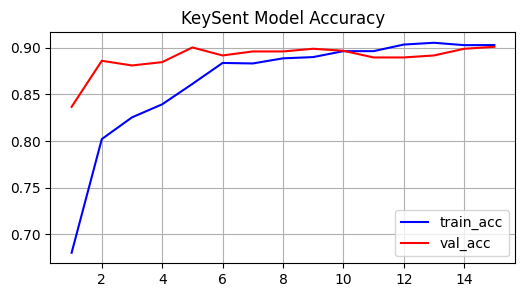

In [37]:
acc = history1.history['accuracy']
val_acc = history1.history['val_accuracy']

epochs = range(1, len(acc)+1)
plt.figure(figsize=(6, 3))
plt.title('KeySent Model Accuracy')
plt.plot(epochs, acc, 'b', label='train_acc')
plt.plot(epochs, val_acc, 'r', label='val_acc')
plt.grid()
plt.legend()
plt.savefig('./KeySentModel_Accuracy_1.png')
plt.show()

In [24]:
key_sent_model_1 = tf.keras.models.load_model(best_model_path1,
                                                  custom_objects={'TFBertForSequenceClassification': TFBertForSequenceClassification})

In [25]:
test_eval_1 = key_sent_model_1.evaluate(test_x, test_y)

49/49 [==============================] - 13s 189ms/step - loss: 0.4783 - accuracy: 0.8992


### # Model 2

In [26]:
dropout = tf.keras.layers.Dropout(0.5)(bert_output)
layer = tf.keras.layers.Dense(256, activation="relu")(dropout)
layer = tf.keras.layers.Dense(128, activation="relu")(layer)
layer = tf.keras.layers.Dense(2, activation='softmax', kernel_initializer = tf.keras.initializers.TruncatedNormal(stddev=0.02))(layer)
key_sent_model_2 = tf.keras.Model([token_inputs, mask_inputs, segment_inputs], layer)

In [27]:
key_sent_model_2.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_word_ids (InputLayer)    [(None, 260)]        0           []                               
                                                                                                  
 input_masks (InputLayer)       [(None, 260)]        0           []                               
                                                                                                  
 input_segment (InputLayer)     [(None, 260)]        0           []                               
                                                                                                  
 tf_bert_for_sequence_classific  TFSequenceClassifie  110618882  ['input_word_ids[0][0]',         
 ation (TFBertForSequenceClassi  rOutput(loss=None,               'input_masks[0][0]',      

In [29]:
key_sent_model_2.compile(optimizer = optimizer, 
                        loss = tf.keras.losses.SparseCategoricalCrossentropy(), 
                        metrics = ['accuracy'])

In [30]:
best_model_path2 = './key_sent_best_model_2.h5'

model_checkpoint2 = ModelCheckpoint(
    filepath = best_model_path2,
    monitor = "val_accuracy",
    mode = "max",
    save_best_only = True, 
    verbose = 1)

In [31]:
callbacks2 = [early_stopping, model_checkpoint2]

In [33]:
epochs = 70
batch_size = 16
history2 = key_sent_model_2.fit(train_x, train_y, 
                    epochs = epochs, 
                    shuffle = True, 
                    batch_size = batch_size, 
                    validation_split= 0.1,
                    callbacks = callbacks2
                    )

Epoch 1/70
789/789 [==============================] - ETA: 0s - loss: 0.4806 - accuracy: 0.6215
Epoch 1: val_accuracy improved from -inf to 0.88294, saving model to ./key_sent_best_model_2.h5
789/789 [==============================] - 299s 334ms/step - loss: 0.4806 - accuracy: 0.6215 - val_loss: 0.4572 - val_accuracy: 0.8829
Epoch 2/70
789/789 [==============================] - ETA: 0s - loss: 0.2456 - accuracy: 0.8488
Epoch 2: val_accuracy improved from 0.88294 to 0.89722, saving model to ./key_sent_best_model_2.h5
789/789 [==============================] - 292s 371ms/step - loss: 0.2456 - accuracy: 0.8488 - val_loss: 0.3005 - val_accuracy: 0.8972
Epoch 3/70
789/789 [==============================] - ETA: 0s - loss: 0.2053 - accuracy: 0.8964
Epoch 3: val_accuracy did not improve from 0.89722
789/789 [==============================] - 258s 327ms/step - loss: 0.2053 - accuracy: 0.8964 - val_loss: 0.3039 - val_accuracy: 0.8929
Epoch 4/70
789/789 [==============================] - ETA: 0s

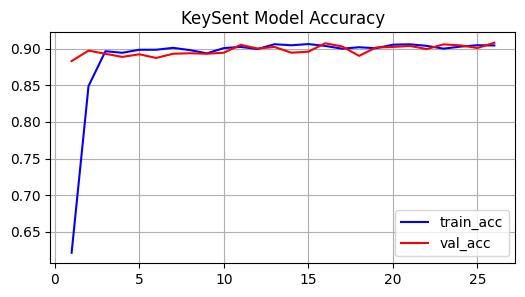

In [34]:
acc = history2.history['accuracy']
val_acc = history2.history['val_accuracy']

epochs = range(1, len(acc)+1)
plt.figure(figsize=(6, 3))
plt.title('KeySent Model Accuracy')
plt.plot(epochs, acc, 'b', label='train_acc')
plt.plot(epochs, val_acc, 'r', label='val_acc')
plt.grid()
plt.legend()
plt.savefig('./KeySentModel_Accuracy_2.png')
plt.show()

In [35]:
key_sent_model_2 = tf.keras.models.load_model(best_model_path2,
                                                  custom_objects={'TFBertForSequenceClassification': TFBertForSequenceClassification})

In [36]:
test_eval_2 = key_sent_model_2.evaluate(test_x, test_y)

49/49 [==============================] - 12s 189ms/step - loss: 0.4579 - accuracy: 0.9037


### # Model 3

In [102]:
dropout = tf.keras.layers.Dropout(0.3)(bert_output)
layer = tf.keras.layers.Dense(512, activation="relu")(dropout)
dropout = tf.keras.layers.Dropout(0.3)(layer)
layer = tf.keras.layers.Dense(256, activation="relu")(dropout)
dropout = tf.keras.layers.Dropout(0.3)(layer)
layer = tf.keras.layers.Dense(2, activation='softmax', kernel_initializer = tf.keras.initializers.TruncatedNormal(stddev=0.02))(layer)
key_sent_model_3 = tf.keras.Model([token_inputs, mask_inputs, segment_inputs], layer)

In [103]:
key_sent_model_3.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_word_ids (InputLayer)    [(None, 260)]        0           []                               
                                                                                                  
 input_masks (InputLayer)       [(None, 260)]        0           []                               
                                                                                                  
 input_segment (InputLayer)     [(None, 260)]        0           []                               
                                                                                                  
 tf_bert_for_sequence_classific  TFSequenceClassifie  110618882  ['input_word_ids[0][0]',         
 ation (TFBertForSequenceClassi  rOutput(loss=None,               'input_masks[0][0]',      

In [104]:
key_sent_model_3.compile(optimizer = optimizer, 
                        loss = tf.keras.losses.SparseCategoricalCrossentropy(), 
                        metrics = ['accuracy'])

In [10]:
best_model_path3 = './key_sent_best_model_3.h5'

model_checkpoint3 = ModelCheckpoint(
    filepath = best_model_path3,
    monitor = "val_accuracy",
    mode = "max",
    save_best_only = True, 
    verbose = 1
)

In [106]:
callbacks3 = [early_stopping, model_checkpoint3]

In [107]:
epochs = 100
batch_size = 16

history3 = key_sent_model_3.fit(train_x, train_y, 
                    epochs = epochs, 
                    shuffle = True, 
                    batch_size = batch_size, 
                    validation_split= 0.1,
                    callbacks = callbacks3
                    )

Epoch 1/100
789/789 [==============================] - ETA: 0s - loss: 0.0845 - accuracy: 0.9580
Epoch 1: val_accuracy improved from -inf to 0.89293, saving model to ./key_sent_best_model_3.h5
789/789 [==============================] - 298s 335ms/step - loss: 0.0845 - accuracy: 0.9580 - val_loss: 0.7208 - val_accuracy: 0.8929
Epoch 2/100
789/789 [==============================] - ETA: 0s - loss: 0.0642 - accuracy: 0.9677
Epoch 2: val_accuracy improved from 0.89293 to 0.89793, saving model to ./key_sent_best_model_3.h5
789/789 [==============================] - 294s 373ms/step - loss: 0.0642 - accuracy: 0.9677 - val_loss: 0.7093 - val_accuracy: 0.8979
Epoch 3/100
789/789 [==============================] - ETA: 0s - loss: 0.0666 - accuracy: 0.9661
Epoch 3: val_accuracy improved from 0.89793 to 0.90007, saving model to ./key_sent_best_model_3.h5
789/789 [==============================] - 303s 384ms/step - loss: 0.0666 - accuracy: 0.9661 - val_loss: 0.7493 - val_accuracy: 0.9001
Epoch 4/10

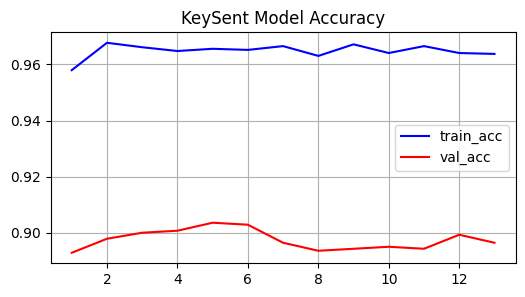

In [111]:
acc = history3.history['accuracy']
val_acc = history3.history['val_accuracy']

epochs = range(1, len(acc)+1)
plt.figure(figsize=(6, 3))
plt.title('KeySent Model Accuracy')
plt.plot(epochs, acc, 'b', label='train_acc')
plt.plot(epochs, val_acc, 'r', label='val_acc')
plt.grid()
plt.legend()
plt.savefig('./KeySentModel_Accuracy_3.png')
plt.show()

In [11]:
key_sent_model_3 = tf.keras.models.load_model(best_model_path3,
                                              custom_objects={'TFBertForSequenceClassification': TFBertForSequenceClassification})

In [12]:
test_eval_3 = key_sent_model_3.evaluate(test_x, test_y)

49/49 [==============================] - 13s 189ms/step - loss: 0.7895 - accuracy: 0.9049


## Evaluation

In [115]:
# 3가지 모델 Accuracy 비교
test_evals = [test_eval_1[1], test_eval_2[1], test_eval_3[1]]
test_evals

[0.8991650342941284, 0.9036608934402466, 0.904945433139801]

In [16]:
# Accuracy가 가장 높은 3번 모델로 평가 진행

predicted_value = key_sent_model_3.predict(test_x)
predicted_label = np.argmax(predicted_value, axis = 1)

49/49 [==============================] - 12s 186ms/step


#### Classification Report

In [17]:
CL_REPORT_FILE = "./cl_report_key_sent.csv"

cl_report = classification_report(test_y, predicted_label, output_dict = True)
cl_report_df = pd.DataFrame(cl_report).transpose()
cl_report_df = cl_report_df.round(3)
cl_report_df.to_csv(CL_REPORT_FILE)
cl_report_df

,precision,recall,f1-score,support
0,0.927,0.913,0.920,930.000
1,0.874,0.893,0.883,627.000
accuracy,0.905,0.905,0.905,0.905
macro avg,0.900,0.903,0.902,1557.000
weighted avg,0.905,0.905,0.905,1557.000


#### Confusion Matrix

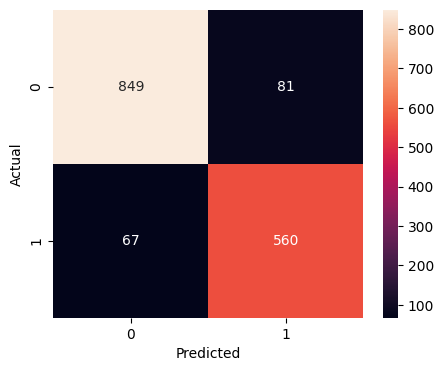

In [18]:
figure_file = "./cf_matrix_key_sent.png"

cf_matrix = confusion_matrix(test_y, predicted_label)
fig, ax = plt.subplots(figsize = (5,4))
sns.heatmap(cf_matrix, annot = True, fmt = 'd')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.savefig(figure_file)
plt.show()

#### Total Metric

In [19]:
accuracy_score = round(accuracy_score(y_test, predicted_label), 3) # Accuracy
precision_score = round(precision_score(y_test, predicted_label, average="weighted"), 3) # Precision
recall_score = round(recall_score(y_test, predicted_label, average="weighted"), 3) # Recall
f1_score = round(f1_score(y_test, predicted_label, average="weighted"), 3) # F1 Score
roc_auc_score = round(roc_auc_score(y_test, predicted_label, average="weighted", multi_class="ovr"), 2) # ROC AUC Score
cohen_kappa_score = round(cohen_kappa_score(y_test, predicted_label), 3) # Cohen's Kappa Score
matthews_corrcoef = round(matthews_corrcoef(y_test, predicted_label), 3) # Matthew's Correlation Coefficient
log_loss = round(log_loss(y_test, predicted_label), 3) # Log Loss

In [22]:
metric_file = './metric_key_sent.csv'

metric_total = pd.DataFrame({
    'PLM': model_name,
    'Optimizer': optimizer_name,
    'Accuracy': accuracy_score,
    'Precision': precision_score,
    'Recall': recall_score,
    'F1_score': f1_score,
    'ROC_AUC_score': roc_auc_score,
    'Cohen_kappa_coef': cohen_kappa_score,
    'Matthews_corrcoef': matthews_corrcoef,
    'Log_loss': log_loss},
     index = ['-'])  

In [23]:
metric_total.to_csv(metric_file)

In [24]:
metric_total

,PLM,Optimizer,Accuracy,Precision,Recall,F1_score,ROC_AUC_score,Cohen_kappa_coef,Matthews_corrcoef,Log_loss
-,klue/bert-base,RAdam,0.905,0.905,0.905,0.905,0.9,0.803,0.803,3.426


### Final Training

In [13]:
key_sent_model_3.fit(test_x, test_y, 
                      epochs=30, 
                      shuffle = True, batch_size = 32)

Epoch 1/30
49/49 [==============================] - 50s 561ms/step - loss: 0.8886 - accuracy: 0.8709
Epoch 2/30
49/49 [==============================] - 27s 561ms/step - loss: 0.7703 - accuracy: 0.8818
Epoch 3/30
49/49 [==============================] - 28s 562ms/step - loss: 0.8609 - accuracy: 0.8767
Epoch 4/30
49/49 [==============================] - 28s 562ms/step - loss: 0.8296 - accuracy: 0.8683
Epoch 5/30
49/49 [==============================] - 28s 562ms/step - loss: 0.6365 - accuracy: 0.8786
Epoch 6/30
49/49 [==============================] - 28s 562ms/step - loss: 0.4096 - accuracy: 0.9069
Epoch 7/30
49/49 [==============================] - 28s 562ms/step - loss: 0.2653 - accuracy: 0.9037
Epoch 8/30
49/49 [==============================] - 28s 562ms/step - loss: 0.2337 - accuracy: 0.9101
Epoch 9/30
49/49 [==============================] - 28s 562ms/step - loss: 0.2199 - accuracy: 0.9216
Epoch 10/30
49/49 [==============================] - 28s 561ms/step - loss: 0.1900 - accura

In [14]:
model_path = "./final_key_sent_model.h5"
key_sent_model_3.save(model_path)